In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import matplotlib
matplotlib.rcParams[u'font.sans-serif'] = ['Taipei Sans TC Beta']
matplotlib.rcParams['axes.unicode_minus'] = False

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Read data

* calendar.csv - Contains information about the dates on which the products are sold.
* sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
* sample_submission.csv - The correct format for submissions. Reference the Evaluation tab for more info.
* sell_prices.csv - Contains information about the price of the products sold per store and date.
* sales_train_evaluation.csv - Includes sales [d_1 - d_1941] (labels used for the Public leaderboard)

In [2]:
calendar = pd.read_csv("./data/calendar.csv")
sales = pd.read_csv("./data/sales_train_evaluation.csv")
selling_prices = pd.read_csv("./data/sell_prices.csv")
sample_submission = pd.read_csv("./data/sample_submission.csv")

##  calendar 資料
* calendar.csv - Contains information about the dates on which the products are sold.
* "weekday"與"wday"有共現關係, 故去除"weekday"方便分析
* "date"與["year","month","wday","wm_yr_wk"]有共現關係, 故去除"date"方便分析
* 由遺失值列表可看出"event_name_1","event_name_2","event_type_1","event_type_2" 有大量缺失值 (>90%)

In [4]:
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [5]:
print('Missing value ratio')
calendar.isnull().mean()[calendar.isnull().mean()>0]

Missing value ratio


event_name_1    0.917725
event_type_1    0.917725
event_name_2    0.997461
event_type_2    0.997461
dtype: float64

## sales_train_validation 資料
* sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
* 隨機抽取8筆產品來觀察趨勢變化, 發現有些資料有週期性, 可抽取一些時間序列的特徵

In [6]:
sales

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


In [7]:
sales.groupby(['state_id','cat_id'])['d_100'].sum()

state_id  cat_id   
CA        FOODS        7425
          HOBBIES      1565
          HOUSEHOLD    2241
TX        FOODS        5429
          HOBBIES       735
          HOUSEHOLD    1276
WI        FOODS        3529
          HOBBIES       580
          HOUSEHOLD     908
Name: d_100, dtype: int64

In [8]:
demand_feature = [f"d_{i+1}" for i in range(1939)] 

1939 天趨勢



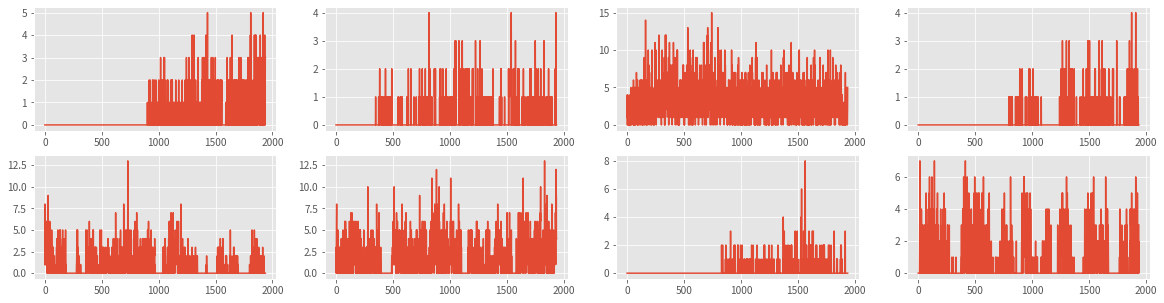

In [9]:
print('1939 天趨勢\n')
plt.figure(8,figsize=(20,5))
for i,color in enumerate(range(8)):    
    plt.subplot(241+i)
    plt.plot(sales[demand_feature].values[1100*i],'-')
plt.show()

100 天趨勢



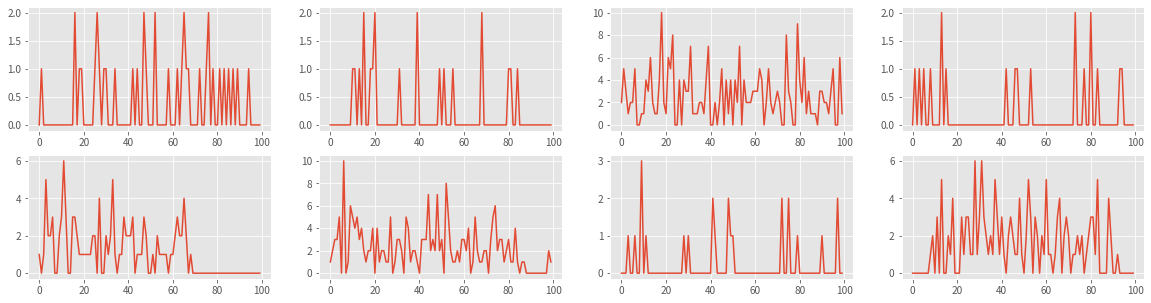

In [10]:
print('100 天趨勢\n')
plt.figure(8,figsize=(20,5))
for i,color in enumerate(range(8)):    
    plt.subplot(241+i)
    plt.plot(sales[demand_feature].values[1100*i][900:1000],'-')
plt.show()

In [11]:
demand_feature_7day = [f"d_{i*7+2}" for i in range(int(1939/7))] 

特定星期 1939 天趨勢



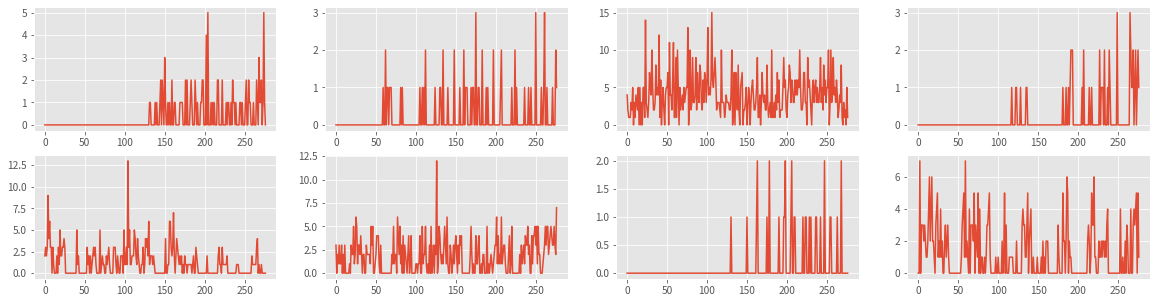

In [12]:
print('特定星期 1939 天趨勢\n')
plt.figure(8,figsize=(20,5))
for i,color in enumerate(range(8)):    
    plt.subplot(241+i)
    plt.plot(sales[demand_feature_7day].values[1100*i],'-')
plt.show()

In [13]:
sales

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


Text(0, 0.5, '銷售總量')

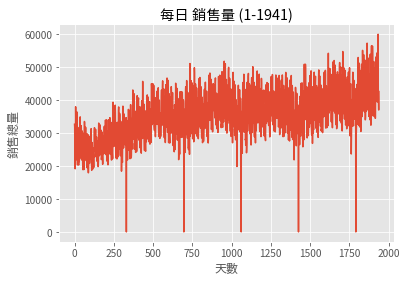

In [14]:
plt.plot(sales[demand_feature].sum(axis=0).values)
plt.title('每日 銷售量 (1-1941)')
plt.xlabel('天數')
plt.ylabel('銷售總量')

Text(0, 0.5, '銷售總量')

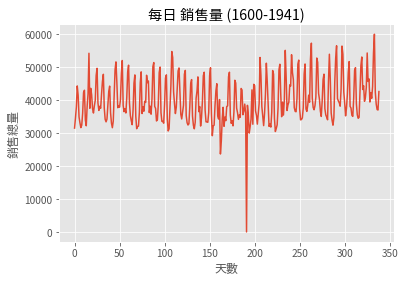

In [25]:
plt.plot(sales[demand_feature].sum(axis=0).values[1600:1941])
plt.title('每日 銷售量 (1600-1941)')
plt.xlabel('天數')
plt.ylabel('銷售總量')

Text(0, 0.5, '銷售總量')

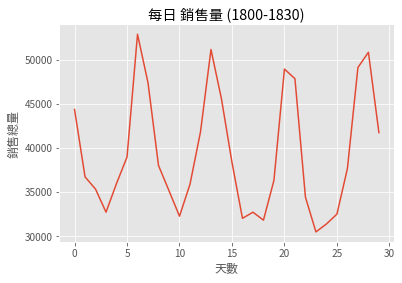

In [26]:
plt.plot(sales[demand_feature].sum(axis=0).values[1800:1830])
plt.title('每日 銷售量 (1800-1830)')
plt.xlabel('天數')
plt.ylabel('銷售總量')

Text(0, 0.5, '比例')

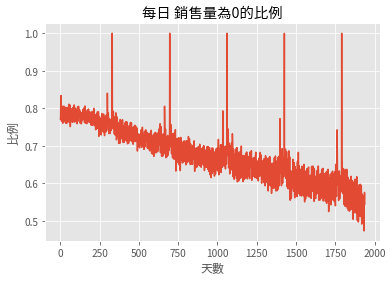

In [27]:
plt.plot((sales[demand_feature]==0).mean(axis=0).values)
plt.title('每日 銷售量為0的比例')
plt.xlabel('天數')
plt.ylabel('比例')

In [18]:
print("資料異常點\n")
print(sales[demand_feature].sum(axis=0)[sales[demand_feature].sum(axis=0)<10000])
print('=='*30)
display(calendar.iloc[330])

資料異常點

d_331     13
d_697     11
d_1062    20
d_1427    20
d_1792    14
dtype: int64


date            2011-12-25
wm_yr_wk             11148
weekday             Sunday
wday                     2
month                   12
year                  2011
d                    d_331
event_name_1     Christmas
event_type_1      National
event_name_2           NaN
event_type_2           NaN
snap_CA                  0
snap_TX                  0
snap_WI                  0
Name: 330, dtype: object

## selling_prices 資料
* sell_prices.csv - Contains information about the price of the products sold per store and date.
* 隨機抽取8個產品 觀察價格變化, 發現價格可能有受到檔期折扣影響 呈現階梯狀

In [19]:
selling_prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [30]:
random_item = np.random.choice(selling_prices['item_id'].unique(),8)

sell price 趨勢



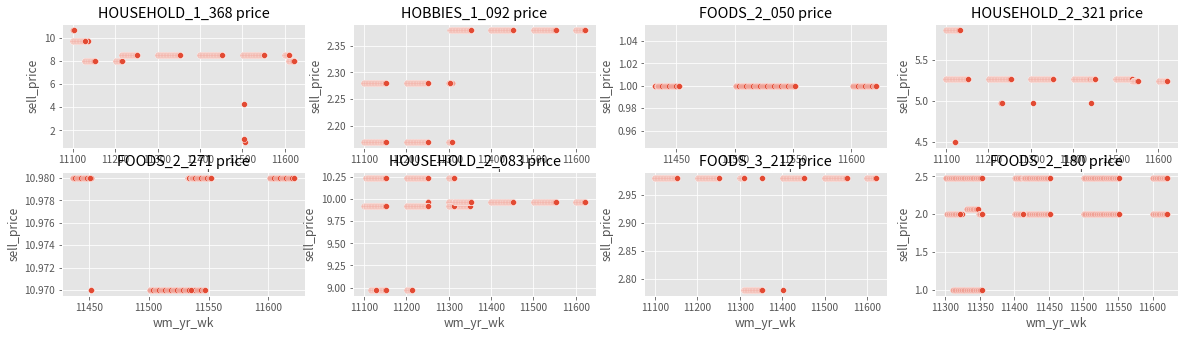

In [31]:
print('sell price 趨勢\n')
plt.figure(8,figsize=(20,5))
for i,item_id in enumerate(random_item):    
    plt.subplot(241+i)
    sns.scatterplot('wm_yr_wk','sell_price',data = selling_prices[selling_prices.item_id==item_id])
    plt.title(f'{item_id} price')
plt.show()

sell price 趨勢 (11300-11470)



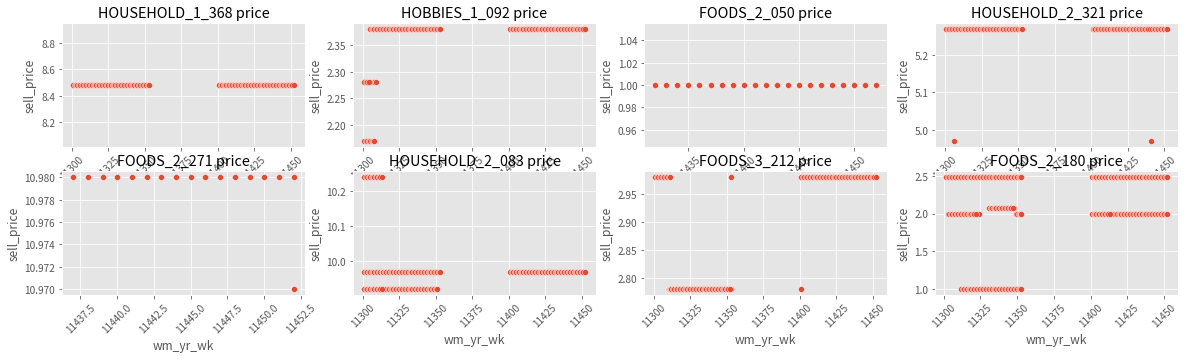

In [36]:
print('sell price 趨勢 (11300-11470)\n')
plt.figure(8,figsize=(20,5))
for i,item_id in enumerate(random_item):    
    plt.subplot(241+i)
    sns.scatterplot('wm_yr_wk','sell_price',data = selling_prices[(selling_prices.item_id==item_id) &\
                                                                  (selling_prices.wm_yr_wk>=11300) &\
                                                                  (selling_prices.wm_yr_wk<=11470) \
                                                                 ]   )
    plt.title(f'{item_id} price')
    plt.xticks(rotation=45)
plt.show()

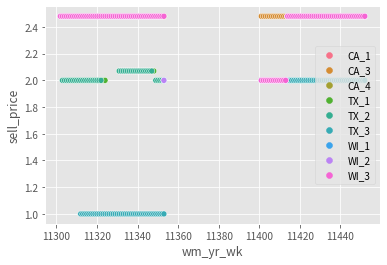

In [37]:
sns.scatterplot('wm_yr_wk','sell_price',hue ='store_id',data = selling_prices[(selling_prices.item_id==item_id) &\
                                                              (selling_prices.wm_yr_wk>=11300) &\
                                                              (selling_prices.wm_yr_wk<=11470) \
                                                             ]   )
plt.legend(loc='center right' )

## sample_submission 資料
* sample_submission.csv - The correct format for submissions. Reference the Evaluation tab for more info.
* 預測未來28天的結果

In [24]:
sample_submission

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60976,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60977,FOODS_3_825_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60978,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
